<p style="font-family:Times;font-size:250%; text-align:center"> <font color='red'>Deep Learning dengan PyTorch</font></p>

# DL2021 - TUGAS 3
## Muhammad Naufal Irham R. (10818019)
Semua code tidak banyak diubah, hanya beberapa bagian tertentu saja yang memang diubah sesuai kebutuhan

In [21]:
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
##Tambahan library
import torch.optim as optim

%matplotlib inline

torch.set_printoptions(precision = 3, profile = 3)   #, suppress = True, formatter = {'float':'{:7.4f}'.format})

#Sigmoid function
sigmoid = lambda Z: 1/(1+torch.exp(-Z))

#Derivative of Sigmoid function/
dsigmoid = lambda A: A*(1-A)

linear = lambda X,w,b: X@w+b

"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in torch.arange(1,step+1):
        xt = torch.hstack((xt, x[i:obs+i,:]))   
    return xt

In [22]:
class NeuralNetwork:
    
    def __init__(self,x,y,hlayers,alpha, method = 0): # ada h nodes di dalam hidden layer
        self.X  = x #input
        self.y  = y #output
        self.α  = alpha
        #Sedikit perubahan
        self.method = method
        
        assert torch.Tensor.dim(y)  == 2   #y harus berupa matriks (berdimensi 2)
        assert type(hlayers) == list
        
        ni = x.shape[1]  #jumlah features (variables)
        self.N, no = y.shape   #jumlah observasi (self.N) dan jumlah output (no)
        
        neurons = [ni]
        neurons.extend(hlayers)
        neurons.append(no)   #jumlah neurons per layer, termasuk input layer 
        self.nlayers  = len(neurons)-1  #number of layers (tidak termasuk input layer)

        "Initial values untuk parameter w and b"
        self.w, self.b = [], []
        for i in torch.arange(self.nlayers):
            self.w.append(torch.randn(neurons[i], neurons[i+1], requires_grad = True))  #Sinapsis dari layer ke i menuju layer ke (i+1)
            self.b.append(torch.randn(1, neurons[i+1], requires_grad = True))           #Bias di layer ke (i+1)    

    def training(self):
        
        "Forward propagation (perambatan maju)"
        Z, A = [], [self.X]
        for j in torch.arange(self.nlayers):
            Z.append(linear(A[j],self.w[j],self.b[j]))  #Reaksi kimia di layer ke (j + 1)
            A.append(sigmoid(Z[j]))     #Aliran listrik di layer ke (j + 1)
    
        self.predicted_y = A[self.nlayers]
        e         = self.y-self.predicted_y
        self.Cost = e.T@e/self.N  #mean squared error

        "Backward propagation (perambatan mundur)"

        #### Modifikasi code dilakukan di bawah ini ##############################
        if self.method == 0: #Backward
            self.Cost.backward()
        
            for n in torch.arange(self.nlayers): 
                with torch.no_grad():
                    self.w[n] -= self.α*self.w[n].grad   #Parameter w di-update 
                    self.b[n] -= self.α*self.b[n].grad   #Parameter b di-update     
                
                    # Manually zero the gradients after running the backward pass
                    self.w[n].grad.zero_()
                    self.b[n].grad.zero_()

        elif self.method == 1: #Grad
            for n in torch.arange(self.nlayers): 
                gradw = torch.autograd.grad(self.Cost, self.w[n], retain_graph=True)
                gradb = torch.autograd.grad(self.Cost, self.b[n], retain_graph=True)
                with torch.no_grad():
                    self.w[n] -= self.α * gradw[0]
                    self.b[n] -= self.α * gradb[0]
            

        elif self.method == 2: #Optim
            self.Cost.backward()
            for n in torch.arange(self.nlayers): 
                optimizer = optim.SGD((self.w[n], self.b[n]), lr = self.α)
                optimizer.step()
                optimizer.zero_grad()

        #############################################################################
                

In [23]:
tic = datetime.now()

LogicGate = {"AND": [[0], [0], [0], [1]], "NAND": [[0], [1], [1], [1]],   "OR": [[0], [1], [1], [1]],
            "XOR": [[0], [1], [1], [0]],  "NOR": [[1], [0], [0], [0]], "XNOR": [[1], [0], [0], [1]]}

X = torch.Tensor([[0,0,0], [0,1,0], [1,0,0], [1,1,1]])
y = torch.Tensor(LogicGate["XNOR"])

hlayers = [3, 2]  #Dua buah hidden layer masing-masing memiliki 3 neutrons dan 2 neutrons
alpha   = 9
epochs  = 300
torch.manual_seed(20201212)

#### Modifikasi code dilakukan di bawah ini ##############################
method = ["Backward", "Grad", "Optim"]
method_index = 0

print("Metode yang digunakan:", method[method_index])

ann1 = NeuralNetwork(X,y,hlayers,alpha,method_index)
#########################################################################

for i in range(epochs): 
    ann1.training()
    
    if (i+1)%(epochs/3) == 0: 
        print ("\nIterasi ke:",i+1)
        print ("Actual vs Predicted Output:")
        prediksi = ann1.predicted_y
        print(torch.cat((y,prediksi), 1))
        
        print ("\nCost:", ann1.Cost.detach().numpy()[0]) 

print('')
print("Waktu yang diperlukan:", datetime.now()-tic)

Metode yang digunakan: Backward

Iterasi ke: 100
Actual vs Predicted Output:
tensor([[1.000, 0.465],
        [0.000, 0.075],
        [0.000, 0.078],
        [1.000, 0.768]], grad_fn=<CatBackward>)

Cost: [0.0879935]

Iterasi ke: 200
Actual vs Predicted Output:
tensor([[1.000, 0.962],
        [0.000, 0.033],
        [0.000, 0.035],
        [1.000, 0.974]], grad_fn=<CatBackward>)

Cost: [0.00112074]

Iterasi ke: 300
Actual vs Predicted Output:
tensor([[1.000, 0.975],
        [0.000, 0.022],
        [0.000, 0.024],
        [1.000, 0.982]], grad_fn=<CatBackward>)

Cost: [0.00051174]

Waktu yang diperlukan: 0:00:00.215203


Metode yang digunakan: Grad
Sampai epoch ke 4000 dicapai akurasi MSE sebesar 0.0008630 dengan waktu 0:00:06.689340
Sampai epoch ke 8000 dicapai akurasi MSE sebesar 0.0006561 dengan waktu 0:00:13.267172
Sampai epoch ke 12000 dicapai akurasi MSE sebesar 0.0006385 dengan waktu 0:00:19.896372
Sampai epoch ke 16000 dicapai akurasi MSE sebesar 0.0006350 dengan waktu 0:00:26.505297
Sampai epoch ke 20000 dicapai akurasi MSE sebesar 0.0006328 dengan waktu 0:00:33.052057

Akurasi dengan data training: 0.0006328 



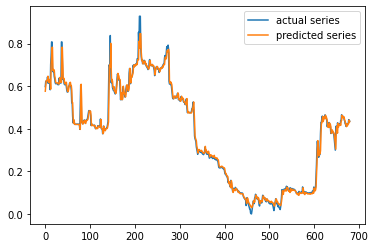

Waktu yang diperlukan dari mulai training (20000 epochs):  0:00:33.219051


In [25]:
#device = torch.device('cpu')
device = torch.device('cuda') # Uncomment this to run on CPU

A  = pd.read_csv('INAF.JK.csv')  #Data time series harian harga saham Intel sejak 02 Januari 2015
A6 = A['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A6.reshape(-1,1)  
                                     
Bmin = min(B)
Bmax = max(B)
b = torch.Tensor((B-Bmin)/(Bmax-Bmin))

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xt = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel y

x = xt[-800:,:]    #Ambil 800 observasi terakhir

#Data untuk training
Xtrain = x[0:680, :-1]  #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:680:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[680:, :-1]  #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[680:, -1:]  #ambil kolom terakhir

hlayers = [3, 2]  #Dua hidden layers, masing-masing dengan 3 neurons dan 2 neurons
alpha   = 8
epochs  = 20000

### Modifikasi code dimulai dari sini ###################################
method = ["Backward", "Grad", "Optim"]
method_index = 1

print("Metode yang digunakan:", method[method_index])

ann2    = NeuralNetwork(Xtrain,ytrain,hlayers,alpha,method_index)
#########################################################################

tic = datetime.now()
torch.manual_seed(20201212)

for t in range(epochs): 
    ann2.training()
    
    if (t+1)%(epochs/5) == 0:   #tampilkan output lima kali
        print("Sampai epoch ke", t+1,"dicapai akurasi MSE sebesar %8.7f" %ann2.Cost,"dengan waktu", datetime.now()-tic)

toc = datetime.now()
print('\nAkurasi dengan data training: %8.7f' %ann2.Cost.detach().numpy(),'\n')

plt.plot(ytrain, label = 'actual series')
plt.plot(ann2.predicted_y.detach().numpy(), label = 'predicted series')
plt.legend()
plt.show()

toc = datetime.now()
print(f'Waktu yang diperlukan dari mulai training ({epochs} epochs): ', toc-tic)


MSE training: 0.0006328 
MSE testing : 0.0018939


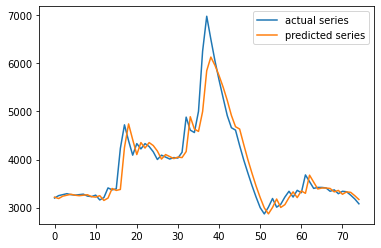

Waktu untuk training (dengan 20000 epochs) dan prediksi:  0:00:00.185006


In [26]:
"Forward propagation (perambatan maju)"
tic = datetime.now()
Z = []
A = [Xtest]
for layer in range(ann2.nlayers):
    Z.append(A[layer]@ann2.w[layer] + ann2.b[layer])
    A.append(sigmoid(Z[layer]))   #Forward propagaation

ytesthat = A[ann2.nlayers]
msetest = (ytest-ytesthat).T@(ytest-ytesthat)/len(ytest)   #MSE semasa testing
print('')
print('MSE training: %8.7f'%ann2.Cost,'\nMSE testing : %7.7f'%msetest)

ytesto    = ytest*(Bmax-Bmin)+Bmin      #Kembalikan datanya ke original unit dalam satuan dolar
ytesthato = ytesthat.detach().numpy()*(Bmax-Bmin)+Bmin   #Kembalikan datanya ke original unit dalam satuan dolar

plt.plot(ytesto, label = 'actual series')
plt.plot(ytesthato, label = 'predicted series')
plt.legend()
plt.show()
toc = datetime.now()

print(f'Waktu untuk training (dengan {epochs} epochs) dan prediksi: ',  toc-tic)